In [12]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt



In [13]:
df = pd.read_csv('preprocessed_posts.csv')
df['token_lem'] = df['token_lem'].apply(lambda x: x.split())
print(type(df['token_lem'][0]))

<class 'list'>


In [14]:
model = Word2Vec(df['token_lem'], min_count=1)

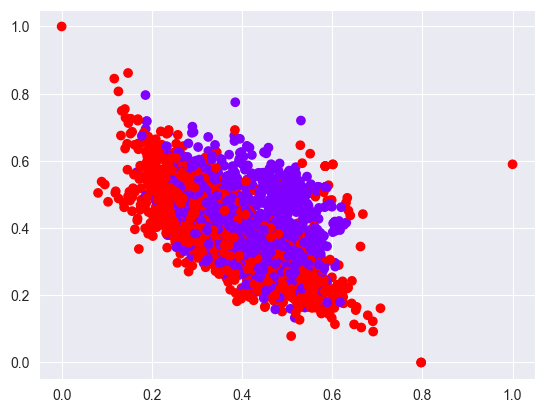

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity


def get_sentence_vector(words):
    vectors = []
    for word in words:
        try:
            vectors.append(model.wv[word])
        except KeyError:
            pass
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)


df['vector'] = df['token_lem'].apply(lambda x: get_sentence_vector(x))
scaler = MinMaxScaler()
X = scaler.fit_transform(np.array(df['vector'].tolist()))

# расчет матрицы сходства
similarity_matrix = cosine_similarity(X)
dbscan = DBSCAN(metric='precomputed', eps=0.75, min_samples=3)
dbscan.fit(similarity_matrix)

# визуализация результатов
plt.scatter(X[:, 0], X[:, 1], c=dbscan.labels_, cmap='rainbow')
plt.show()

Epsilon: 0.5
Only 1 cluster
Epsilon: 0.5368421052631579
Only 1 cluster
Epsilon: 0.5736842105263158
Only 1 cluster
Epsilon: 0.6105263157894737
Only 1 cluster
Epsilon: 0.6473684210526316
Only 1 cluster
Epsilon: 0.6842105263157895
Estimated number of clusters: 3
Estimated number of noise points: 3399
Epsilon: 0.7210526315789474
Estimated number of clusters: 3
Estimated number of noise points: 2926
Epsilon: 0.7578947368421052
Estimated number of clusters: 1
Estimated number of noise points: 1332
Epsilon: 0.7947368421052632
Estimated number of clusters: 1
Estimated number of noise points: 104
Epsilon: 0.831578947368421
Estimated number of clusters: 1
Estimated number of noise points: 2
Epsilon: 0.868421052631579
Only 1 cluster
Epsilon: 0.9052631578947368
Only 1 cluster
Epsilon: 0.9421052631578947
Only 1 cluster
Epsilon: 0.9789473684210526
Only 1 cluster
Epsilon: 1.0157894736842104
Only 1 cluster
Epsilon: 1.0526315789473684
Only 1 cluster
Epsilon: 1.0894736842105264
Only 1 cluster
Epsilon: 1

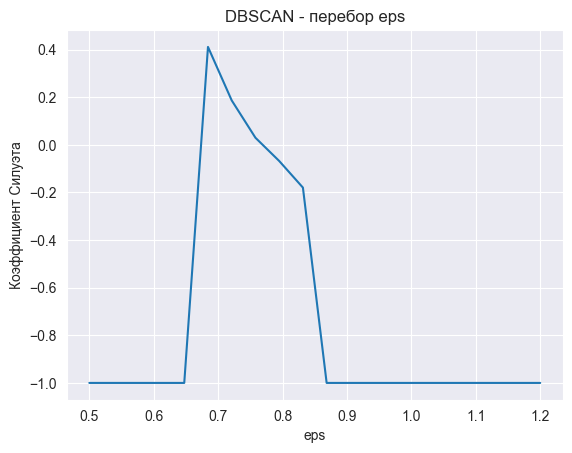

In [24]:

eps_values = np.linspace(0.5, 1.2, 20)
silhouette_values = []
for eps in eps_values:
    db = DBSCAN(metric='precomputed', eps=eps, min_samples=10).fit(similarity_matrix)
    labels = db.labels_
    if len(set(labels)) < 2:
        print("Epsilon:", eps)
        print("Only 1 cluster")
        silhouette_values.append(-1)
        continue

    silhouette_values.append(silhouette_score(similarity_matrix, labels))
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print("Epsilon:", eps)
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
best_eps = eps_values[np.argmax(silhouette_values)]
print("The optimal epsilon value is: ", best_eps)
plt.plot(eps_values, silhouette_values)
plt.xlabel('eps')
plt.ylabel('Коэффициент Силуэта')
plt.title('DBSCAN - перебор eps')
plt.show()

In [7]:
def incr(a: list):
    a = [123]


a = [12]
print(a)
print(id(a))
incr(a)
print(a)
print(id(a))

[12]
2719704199680
[12]
2719704199680


In [9]:
import sys
arr_1 = []
arr_2 = arr_1
print(sys.getrefcount(arr_1))
print(sys.getrefcount(arr_2))

3
3


In [10]:
class Variable:

   def __init__(self, name, value):
      self._name = name
      self._value = value

   @property
   def value(self):
      print(self._name, 'GET', self._value)
      return self._value

   @value.setter
   def value(self, value):
      print(self._name, 'SET', self._value)
      self._value = value

var_1 = Variable('var_1', 'val_1')
var_2 = Variable('var_2', 'val_2')
var_1.value, var_2.value = var_2.value, var_1.value

var_2 GET val_2
var_1 GET val_1
var_1 SET val_1
var_2 SET val_2


In [13]:
def f_g():
   yield 43
   return 66

print(f_g())

<generator object f_g at 0x000002793B015B60>
